В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import tqdm
import random
import os

from tqdm import tqdm
from torch import nn
from torchvision import transforms
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

In [2]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
def plot_history(train_history, val_history, title="Loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="Train", c="darkcyan", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="red", label="Val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()
    
    plt.show()

In [57]:
set_random_seed(1997)
def train_one_epoch(model, train_dataloader, criterion, optimizer, epoch, device):
    train_losses = []
    train_hits = 0
    train_size = 0
    
    model.train()
    for imgs, labels in tqdm(train_dataloader, desc=f"Training. Epoch {epoch + 1}", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        y_pred = model(imgs)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_losses.append(loss.item())
        
        pred_classes = torch.argmax(y_pred, dim=-1)
        train_hits += (pred_classes == labels).sum().item()
        train_size += y_pred.size(0)
    return train_losses, train_hits / train_size  # Loss_list, Accuracy

def predict(model, val_dataloder, criterion, device):
    val_losses = []
    true_classes = torch.Tensor([]).to(device)
    predicted_classes = torch.Tensor([]).to(device)
    
    model.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(val_dataloader, desc="Validating.", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            val_losses.append(loss.item())
            
            batch_pred_classes = torch.argmax(y_pred, dim=-1)
            predicted_classes = torch.cat((predicted_classes, batch_pred_classes), dim=0)
            true_classes = torch.cat((true_classes, labels), dim=0)
            
    return val_losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs=10, scheduler=None):
    model.to(device)
    epochs_train_loss, epochs_train_accuracy = [], []  # List of Loss, Accuracy per epoch on train
    epochs_val_loss, epochs_val_accuracy = [], []      # List of Loss, Accuracy per epoch on val
    
    for epoch in range(n_epochs):
        # Train Accuracy and Losses
        train_losses, train_accuracy = train_one_epoch(model, train_dataloader, criterion, optimizer, epoch, device)
        epochs_train_loss.append(np.mean(train_losses))
        epochs_train_accuracy.append(train_accuracy)
        
        # Val Accuracy and Losses
        val_losses, val_pred, val_true = predict(model, val_dataloader, criterion, device)
        epochs_val_loss.append(np.mean(val_losses))
        epochs_val_accuracy.append((val_pred == val_true).sum().item() / val_true.size(0))
        
        # Scheduler step
        if scheduler:
            scheduler.step(epochs_val_loss[-1])
        
        # Printing epoch results
        clear_output()
        results = pd.DataFrame({'Train Loss': epochs_train_loss, 
                                'Val Loss': epochs_val_loss, 
                                'Train Acc:': epochs_train_accuracy, 
                                'Val Acc:': epochs_val_accuracy})
        print(results)
        plot_history(train_losses, epochs_val_loss)
    # return results

In [11]:
set_random_seed(1997)

train_transform = transforms.Compose([
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))
])

train_dataset = torchvision.datasets.ImageFolder("../input/iad-img-classification/dataset/dataset/train", transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder("../input/iad-img-classification/dataset/dataset/val", transform=val_transform)

In [12]:
train_rand = np.random.choice(len(train_dataset), 5000, replace=False)
val_rand = np.random.choice(len(val_dataset), 500, replace=False)
train_SUBSET = torch.utils.data.Subset(train_dataset, train_rand)
val_SUBSET = torch.utils.data.Subset(val_dataset, val_rand)

train_dataloader = torch.utils.data.DataLoader(train_SUBSET, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_SUBSET, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

### Качаем предобученные модели

In [13]:
import torchvision.models as models

resnet152 = models.resnet152(pretrained=True)
densenet = models.densenet161(pretrained=True)
vgg16 = models.vgg16_bn(pretrained=True)
googlenet = models.googlenet(pretrained=True)
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

### Фиксируем градиенты и меняем выходной слой

In [18]:
for model in [resnet152, densenet, vgg16, googlenet, mobilenet_v3_large]:
    for param in model.parameters():
        param.requires_grad = False

In [19]:
resnet152.fc = nn.Linear(2048, 200)
densenet.classifier = nn.Linear(2208, 200)
vgg16.classifier._modules['6'] = nn.Linear(4096, 200)
googlenet.fc = nn.Linear(1024, 200)
mobilenet_v3_large.classifier._modules['3'] = nn.Linear(1280, 200)

### Обучаем на нескольких эпохах, чтобы сравнить качество в динамике

In [42]:
set_random_seed(1997)

for model in [resnet152, densenet, vgg16, googlenet, mobilenet_v3_large]:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(densenet.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    print(f"{model}".split('(')[0])
    print(train(densenet, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs=3, scheduler=scheduler))

ResNet


   Train Loss  Val Loss  Train Acc:  Val Acc:
0    1.749675  2.456995      0.7558     0.470
1    1.689486  2.467783      0.7582     0.470
2    1.651937  2.424958      0.7690     0.468
DenseNet


   Train Loss  Val Loss  Train Acc:  Val Acc:
0    1.611353  2.373114      0.7630     0.476
1    1.540587  2.369529      0.7816     0.474
2    1.501085  2.339211      0.7868     0.456
VGG


   Train Loss  Val Loss  Train Acc:  Val Acc:
0    1.459822  2.309170      0.7890     0.466
1    1.427819  2.299314      0.7920     0.462
2    1.393636  2.283117      0.7918     0.468
GoogLeNet


   Train Loss  Val Loss  Train Acc:  Val Acc:
0    1.360183  2.277075      0.7952     0.470
1    1.308970  2.247540      0.8058     0.476
2    1.279297  2.227589      0.8156     0.482
MobileNetV3


   Train Loss  Val Loss  Train Acc:  Val Acc:
0    1.260809  2.196769      0.8118     0.486
1    1.207397  2.193490      0.8248     0.482
2    1.182500  2.197823      0.8266     0.478


Все модели упираются в потолок 0.5 и с каждой новой эпохой не улучшают качество (где-то оно даже падает). 
Поэтому нужны более продвинутые модели...

### Очистим память перед следующей моделью
С помощью такого метода в оперативке все равно что-то остается, поэтому без перезапуска ядра точно избежать проблему `CUDA out of memory` невозможно.

In [44]:
import gc
torch.cuda.empty_cache()
del resnet152, densenet, vgg16, googlenet, mobilenet_v3_large
gc.collect()

11685

In [45]:
print(torch.cuda.memory_summary(device=device))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    9136 MB |   10290 MB |  450102 GB |  450093 GB |
|       from large pool |    9079 MB |   10285 MB |  449672 GB |  449663 GB |
|       from small pool |      57 MB |      91 MB |     430 GB |     430 GB |
|---------------------------------------------------------------------------|
| Active memory         |    9136 MB |   10290 MB |  450102 GB |  450093 GB |
|       from large pool |    9079 MB |   10285 MB |  449672 GB |

# Efficient Net

Утверждается, что эта модель дает более высокий accuracy при меньшем числе обучаемых параметров. \
Github: https://github.com/lukemelas/EfficientNet-PyTorch
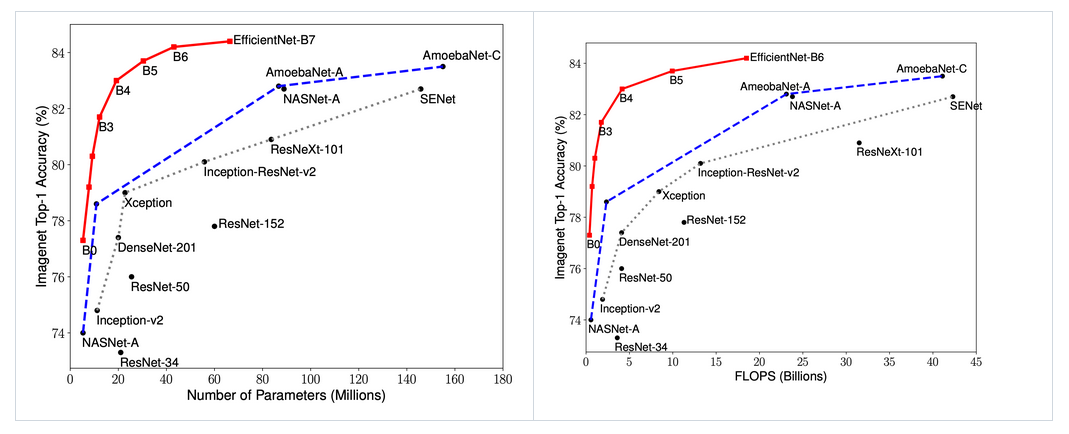

In [46]:
!pip install efficientnet_pytorch

from efficientnet_pytorch import EfficientNet
effnet7 = EfficientNet.from_pretrained('efficientnet-b7')

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b3e6bb7c0719bb9f49ab9ffa6ceab97f6ed76aba30314e2f84f7340db02aa8a8
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


In [58]:
for param in effnet7.parameters():
    param.requires_grad = False

effnet7._fc = nn.Linear(2560, 200)

In [59]:
set_random_seed(1997)
# Подгружаем полный датасет, а не подвыборку.
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

   Train Loss  Val Loss  Train Acc:  Val Acc:
0    4.294014  3.405571     0.42306    0.5718
1    3.085723  2.648865     0.53606    0.5838


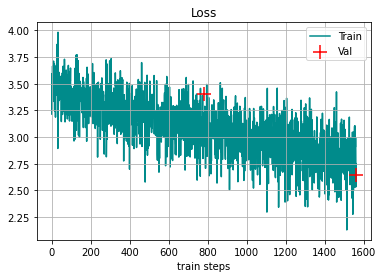

In [61]:
set_random_seed(1997)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnet7.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train(effnet7, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs=2, scheduler=scheduler)

В целом норм, но даже если обучать еще эпох 20-30, то не факт что можно пробить 0.8. А это десятки часов...
Поэтому возьмем еще более крутую модельку, которая за 1 эпоху пробивает порог)

# ViT (Visual Transformers)

Такие модели вместо обычных сверток используют токены, которые выделяют наиболее важные части изображения. 
Таким образом, уделяется внимание только значимым объектам на картинке и игнорируется background.

Kaggle с описанием работы:
https://www.kaggle.com/raufmomin/vision-transformer-vit-fine-tuning/notebook \
Официальная документация модели:
https://pypi.org/project/pytorch-pretrained-vit/ \
Статья с результатами обучения:
https://arxiv.org/pdf/2010.11929.pdf \
Популярный обзор на то, как работают visual transformers:
https://habr.com/ru/company/ru_mts/blog/512258/

Будем использовать `L_16_imagenet1k`, превосходящий другие вариации модели.

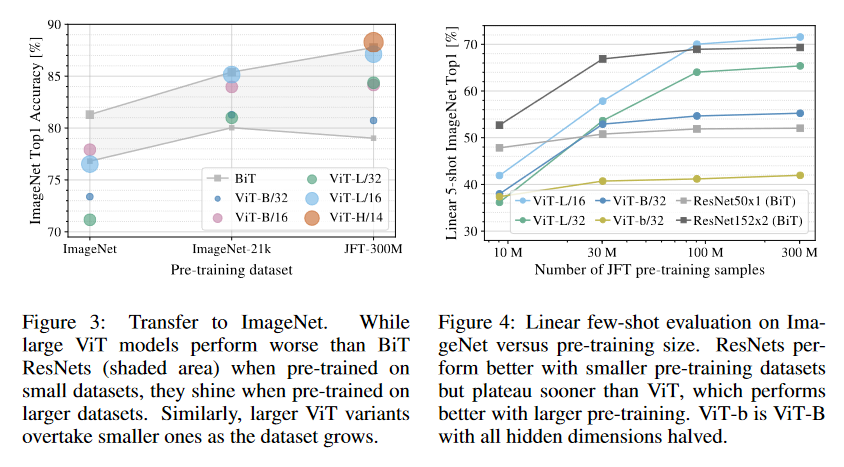

In [5]:
set_random_seed(1997)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))
])

val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))
])

train_dataset = torchvision.datasets.ImageFolder("../input/iad-img-classification/dataset/dataset/train", transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder("../input/iad-img-classification/dataset/dataset/val", transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
!pip install pytorch_pretrained_vit

from pytorch_pretrained_vit import ViT
# vit32 = ViT('L_32_imagenet1k', pretrained=True)
vit16 = ViT('L_16_imagenet1k', pretrained=True)

  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11131 sha256=e8a5fda5610e70a407ed27f7d1cc6e6216c197b1ec10720edc62c3cd8fcdfcd5
  Stored in directory: /root/.cache/pip/wheels/87/1d/d1/c6852ef6d18565e5aee866432ab40c6ffbd3411d592035cddb
Successfully built pytorch-pretrained-vit


Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/L_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/L_16_imagenet1k.pth


  0%|          | 0.00/1.14G [00:00<?, ?B/s]

Loaded pretrained weights.


In [7]:
for param in vit16.parameters():
    param.requires_grad = False

vit16.fc = nn.Linear(1024, 200)

In [8]:
next(iter((vit16.parameters())))

Parameter containing:
tensor([[[-0.0022,  0.0359, -0.0006,  ...,  0.0191, -0.0091, -0.0169]]])

   Train Loss  Val Loss  Train Acc:  Val Acc:
0    1.121433  0.596564      0.7903    0.8531


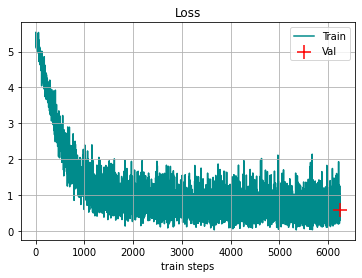

In [9]:
set_random_seed(1997)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit16.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train(vit16, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs=1, scheduler=scheduler)

In [10]:
_, predicted_labels, true_labels = predict(vit16, val_dataloader, criterion, device)
accuracy_score(true_labels.cpu(), predicted_labels.cpu())

0.8531

# [OWNED.](https://en.wikipedia.org/wiki/Owned_(slang))